In [9]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa  # this is critical to load Addons>AdamW

In [27]:
# Helper function to inspect layer names in a model
def inspect_model_layers(model):
    """Prints all layer names in the model for identifying the last convolutional layer."""
    for idx, layer in enumerate(model.layers):
        print(f"Layer {idx}: {layer.name}, Type: {type(layer)}")

In [28]:
def get_gradcam(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)  # (1, H, W, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    conv_outputs = conv_outputs[0]  # (H, W, C)

    # weight each channel by the corresponding gradient
    weighted_output = conv_outputs * pooled_grads  # (H,W,C)

    heatmap = tf.reduce_sum(weighted_output, axis=-1)  # (H,W)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # normalize
    return heatmap.numpy(), class_idx.numpy()


In [44]:
def overlay_heatmap(heatmap, img, alpha=0.4):
    """Overlay the GradCAM heatmap onto the original image."""
    if tf.is_tensor(heatmap):
        heatmap = heatmap.numpy()

    print(f"heatmap.shape = {heatmap.shape}, min={np.min(heatmap)}, max={np.max(heatmap)}")

    if heatmap.ndim != 2:
        raise ValueError(f"Heatmap has unexpected shape: {heatmap.shape}")

    if np.isnan(heatmap).any() or np.all(heatmap == 0):
        raise ValueError(f"Heatmap contains NaNs or is all zeros")

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    output = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return output


In [13]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model, Input


def cbam_block(inputs, reduction=16):
    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    shared_dense = layers.Dense(inputs.shape[-1] // reduction, activation='relu')
    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    channel = layers.Add()([avg_out, max_out])
    channel = layers.Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = layers.Reshape((1, 1, inputs.shape[-1]))(channel)
    x = layers.Multiply()([inputs, channel])
    # Spatial Attention
    avg_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_spatial, max_spatial])
    spatial = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, spatial])

def crm_block(x):
    edge = tf.image.sobel_edges(x)
    edge_mean = tf.reduce_mean(edge, axis=-1, keepdims=True)
    stat_mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    stat_mean = tf.tile(stat_mean, [1, x.shape[1], x.shape[2], 1])
    x_cat = layers.Concatenate(axis=-1)([edge_mean[..., 0], stat_mean])
    attention = layers.Conv2D(x.shape[-1], (1, 1), activation='sigmoid')(x_cat)
    return layers.Multiply()([x, attention])

def build_model(input_shape=(320, 320, 3), num_classes=4):
    base = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False
    x = base.output
    x = cbam_block(x)
    x = crm_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=outputs)
    return model

In [15]:
# Paths to the trained model
base_path = "../"
model_path = f"EyeNet_Model.h5"
# model_path = f"EyeNet_Model.h5"

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

model = build_model(input_shape=(320, 320, 3), num_classes=4)
model.load_weights("EyeNet_Model.h5")

# Inspect layer names to find the last convolutional layer
print("Inspecting Multiclass Model layers:")
inspect_model_layers(model)

Inspecting Multiclass Model layers:
Layer 0: input_3, Type: <class 'keras.engine.input_layer.InputLayer'>
Layer 1: zero_padding2d_4, Type: <class 'keras.layers.reshaping.zero_padding2d.ZeroPadding2D'>
Layer 2: conv1/conv, Type: <class 'keras.layers.convolutional.conv2d.Conv2D'>
Layer 3: conv1/bn, Type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
Layer 4: conv1/relu, Type: <class 'keras.layers.core.activation.Activation'>
Layer 5: zero_padding2d_5, Type: <class 'keras.layers.reshaping.zero_padding2d.ZeroPadding2D'>
Layer 6: pool1, Type: <class 'keras.layers.pooling.max_pooling2d.MaxPooling2D'>
Layer 7: conv2_block1_0_bn, Type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
Layer 8: conv2_block1_0_relu, Type: <class 'keras.layers.core.activation.Activation'>
Layer 9: conv2_block1_1_conv, Type: <class 'keras.layers.convolutional.conv2d.Conv2D'>
Layer 10: conv2_block1_1_bn, Type: <class 'keras.layers.normalization.batch_normaliza

In [34]:
# Update the last convolutional layer name after inspection
last_conv_layer_name = "multiply_8"

# Preprocess eye image
def preprocess_eye_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, (320, 320)) / 255.0
    return np.expand_dims(img, axis=0)

# Analyze eye image
def analyze_eyes(eye_image_path, model):
    """
    Analyze the eye image using the trained model.
    Returns the predicted class and confidence percentages for all classes.
    """
    # Preprocess the image
    processed_image = preprocess_eye_image(eye_image_path)

    # Make prediction
    predictions = model.predict(processed_image)[0]
    classes = ["Cataract", "Conjunctivitis", "Healthy", "Stye"]
    confidences = {classes[i]: predictions[i] * 100 for i in range(len(classes))}
    predicted_class = classes[np.argmax(predictions)]
    return predicted_class, confidences

heatmap.shape = (10, 10), min=0.0, max=1.0


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4030: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


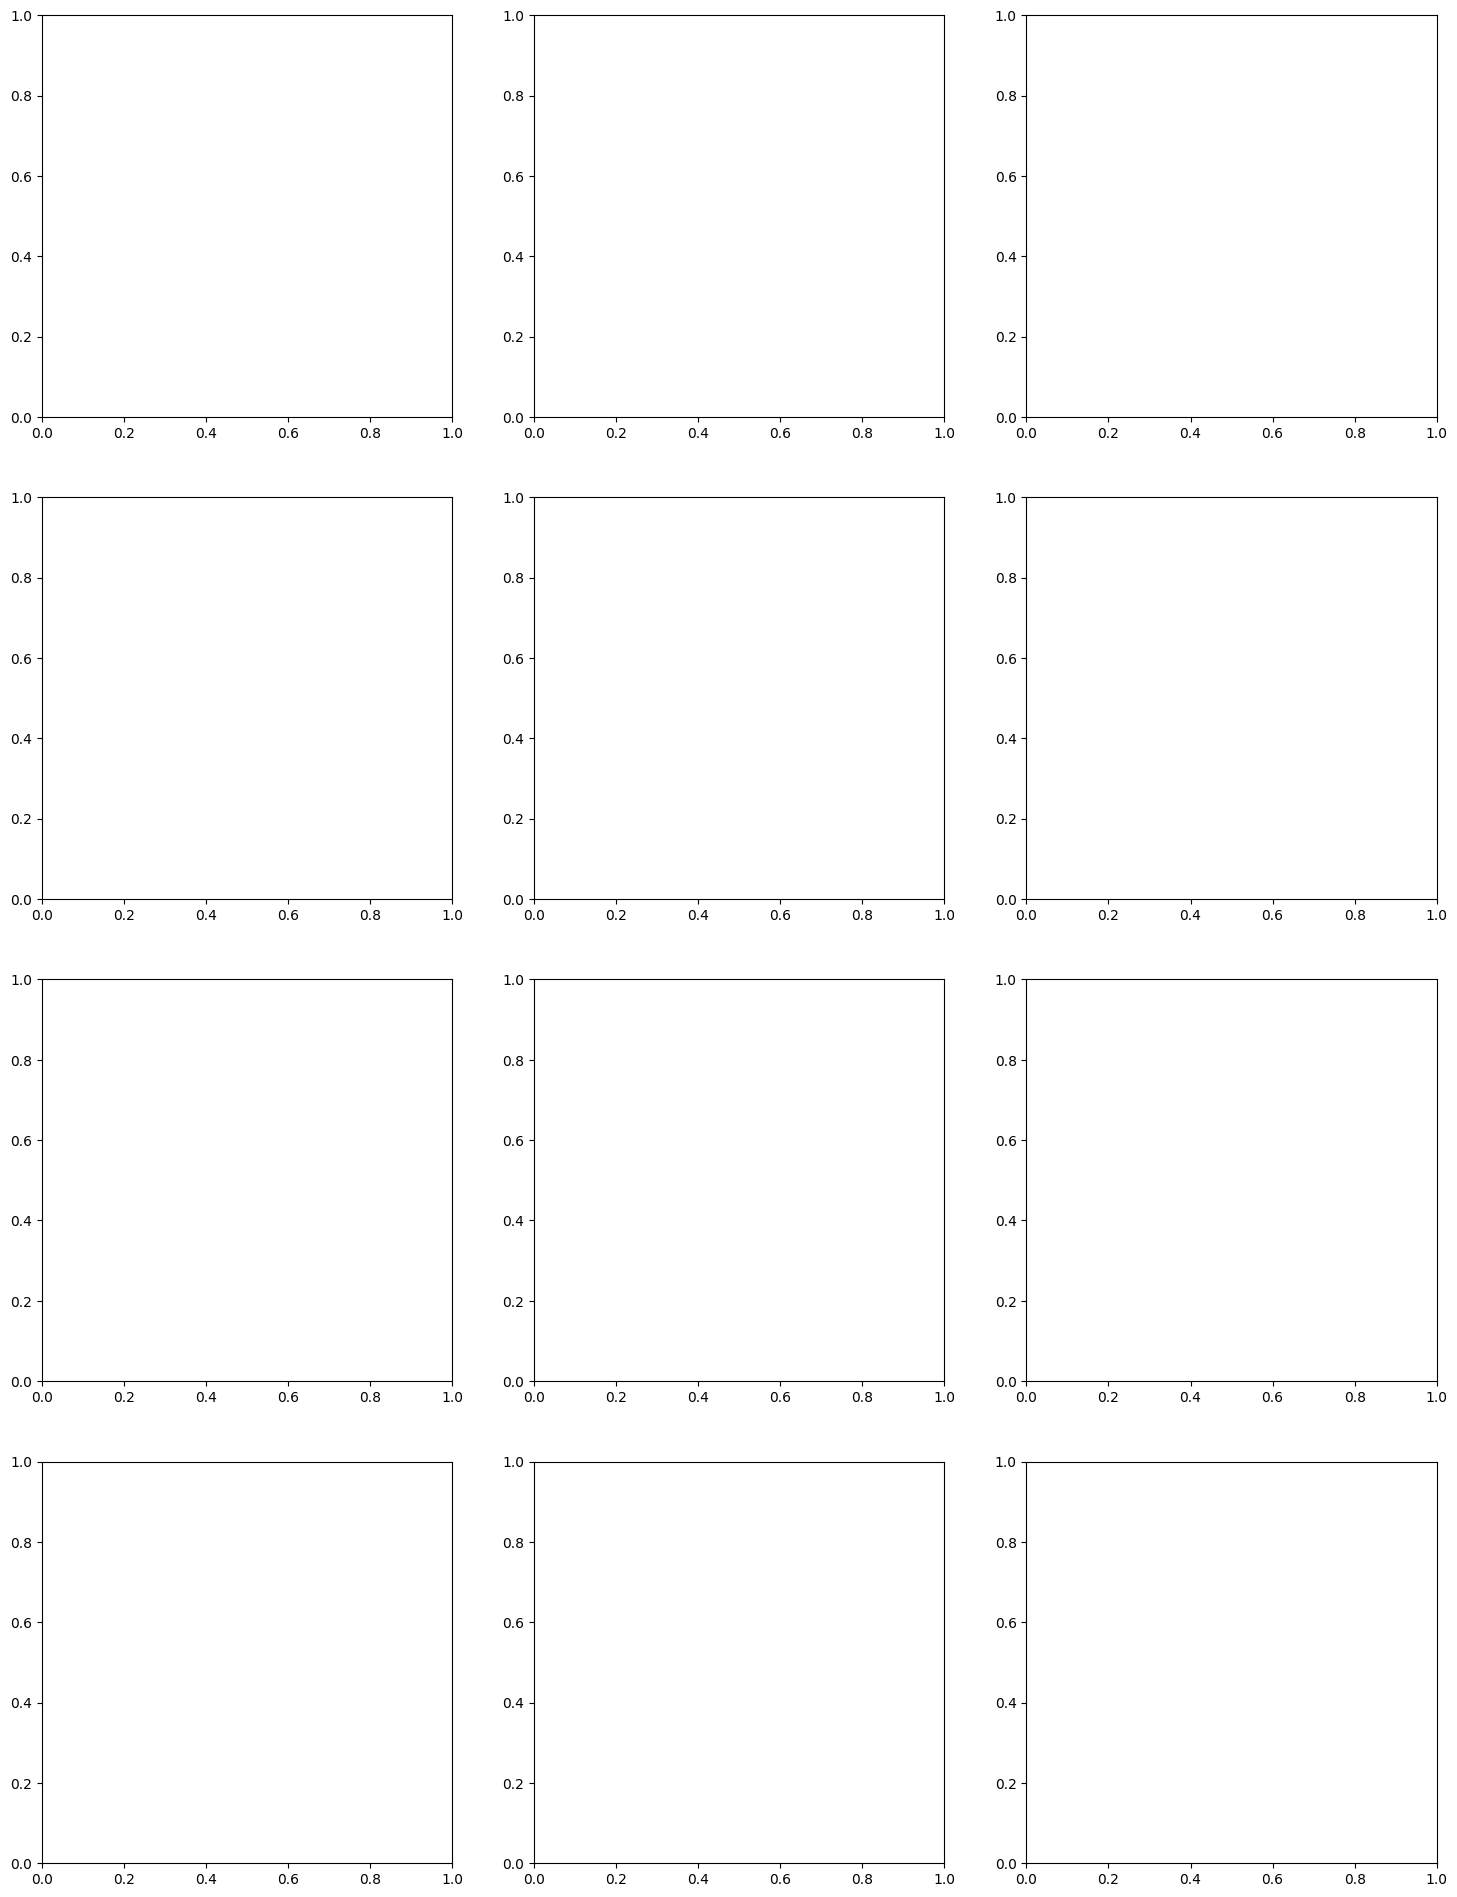

In [41]:
# Paths to input images
input_images = {
    "Healthy": "input_heal.jpg",
    "Cataract": "input_cat.jpg",
    "Conjunctivitis": "input_conj.jpg",
    "Stye": "input_st.jpg",
}

# Generate the comparison figure
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
classes = ["Healthy", "Cataract", "Conjunctivitis", "Stye"]

for i, cls in enumerate(classes):
    # Load and preprocess the input image
    img_path = input_images[cls]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = tf.image.resize(img, (320, 320)) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Generate GradCAM and predictions
    heatmap, _ = get_gradcam(model, img_array, last_conv_layer_name)
    gradcam_img = overlay_heatmap(heatmap, img)
    predicted_label, confidences = analyze_eyes(img_path, model)

    # Plot original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original Image ({cls})")
    axes[i, 0].axis("off")

    # Plot GradCAM image
    axes[i, 1].imshow(gradcam_img)
    axes[i, 1].set_title("GradCAM Image")
    axes[i, 1].axis("off")

    # Display prediction results
    prediction_text = f"Predicted: {predicted_label}\n"
    prediction_text += "\n".join([f"{cls}: {conf:.2f}%" for cls, conf in confidences.items()])
    axes[i, 2].text(0.5, 0.5, prediction_text, fontsize=12, ha="center", va="center")
    axes[i, 2].set_title("Prediction Results")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()